<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/Lab06_SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [8]:
path_train = 'data/xray/covid19/train/'
path_valid = 'data/xray/covid19/valid/'

## 영상데이터에 대한 전처리과정 정의하기

In [9]:
train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

## ImageFolder를 활용하여 data loader를 생성하기

In [10]:
batch_size = 32

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [11]:
tgtnames = trainset.classes
print(tgtnames)

['covid19', 'normal', 'opacity']


In [26]:
print(len(trainset),len(validset))

1200 300


torch.Size([32, 1, 64, 64])
torch.Size([32])


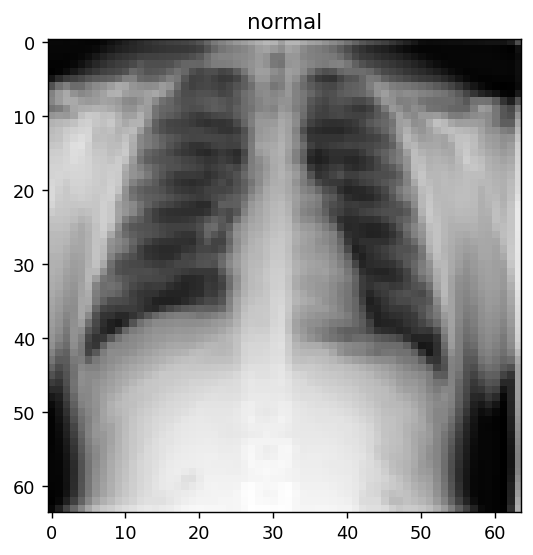

In [12]:
for X, y in trainloader:
  print(X.shape)
  print(y.shape)
  I = X[0][0].numpy()
  plt.figure(dpi=128)
  plt.imshow(I,cmap='gray')
  plt.title(tgtnames[y[0]])
  plt.show()
  break

## CNN model을 정의해보기

In [13]:
mycnn = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=6*32*32, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 3),
)
mycnn = mycnn.to(device)
print(mycnn)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=6144, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=3, bias=True)
)


## Hyperparameter의 설정

In [14]:
# setting hyper-parameters
learning_rate = .1
num_epochs = 30

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(mycnn.parameters(),lr=learning_rate) # sgd

## Model 학습 진행

In [15]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    mycnn.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    mycnn.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  1.0839156100624485
train accuracy:  0.4050000011920929
valid accuracy:  0.44999998807907104
epoch: 5 
train loss:  0.7115976434004935
train accuracy:  0.70333331823349
valid accuracy:  0.6366666555404663
epoch: 10 
train loss:  0.6077354330765573
train accuracy:  0.7516666650772095
valid accuracy:  0.6499999761581421
epoch: 15 
train loss:  0.5188162954230058
train accuracy:  0.784166693687439
valid accuracy:  0.7699999809265137
epoch: 20 
train loss:  0.454569515429045
train accuracy:  0.8116666674613953
valid accuracy:  0.7666666507720947
epoch: 25 
train loss:  0.40891361236572266
train accuracy:  0.8291666507720947
valid accuracy:  0.7866666913032532


## 학습과정의 요약

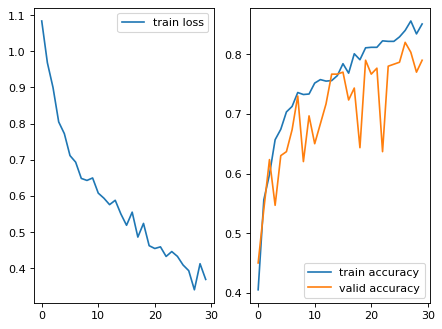

In [16]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()
     

## Validation set에 대한 개별결과 확인 (Inference)

In [17]:
from PIL import Image

In [18]:
N = 42
#validset.imgs[N][0]

covid19


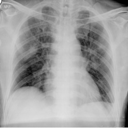

In [19]:
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
I


In [20]:
y_hat = mycnn(X.unsqueeze(1).to(device))
print(y_hat.cpu().detach().numpy())
y_hat = y_hat.argmax(dim=1)
print(f'prediction of mycnn: {tgtnames[y_hat.cpu().numpy()[0]]}')

[[ 7.7127247 -0.9454094 -6.52646  ]]
prediction of mycnn: covid19


## Validation set에 대한 결과 요약하기

In [21]:
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = mycnn(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

In [22]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [23]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

     covid19       0.79      0.86      0.82       100
      normal       0.77      0.88      0.82       100
     opacity       0.83      0.63      0.72       100

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



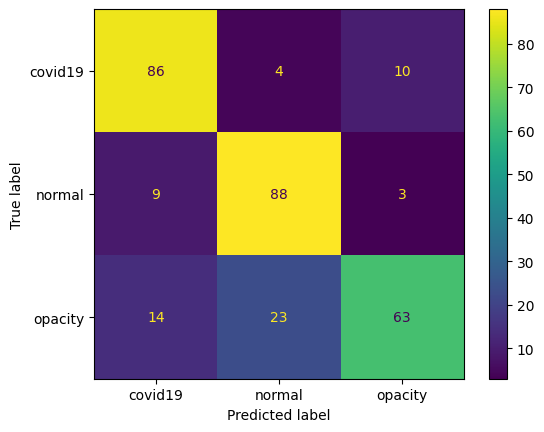

In [24]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])
     